In [1]:
import logging
import os
import torch
from torch.utils.data import DataLoader
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from utils import setup_logging
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import visualize_single_volume
from utils.utils import load_config

train = False
dataset = "dbrain"
# Setup logging
log_file = setup_logging(log_level=logging.INFO)
logging.info(f"Starting training with dataset: {dataset}")

# Get the directory where this script is located
script_dir = "/home/paco/TechJourney/TechJourney/DWMRI/src/drcnet"
config_path = os.path.join(script_dir, "config.yaml")

logging.info(f"Loading config from: {config_path}")

settings = load_config(config_path)
logging.info("Configuration loaded successfully")

if dataset == "dbrain":
    logging.info("Using DBrain dataset configuration")
    settings = settings.dbrain
    data_loader = DBrainDataLoader(
        nii_path=settings.data.nii_path,
        bvecs_path=settings.data.bvecs_path,
        bvalue=settings.data.bvalue,
        noise_sigma=settings.data.noise_sigma,
    )
original_data, noisy_data = data_loader.load_data()
take_volumes = settings.data.num_b0s + settings.data.num_volumes
logging.info(
    f"Taking volumes from {settings.data.num_b0s} to {take_volumes}"
)
noisy_data = noisy_data[
    : settings.data.take_x,
    : settings.data.take_y,
    : settings.data.take_z,
    settings.data.num_b0s : take_volumes,
]


/home/paco/vqvae/env-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-04 20:58:26,546 - root - INFO - Logging configured - level: INFO, file: logs/training_20250804_205826.log
2025-08-04 20:58:26,547 - root - INFO - Starting training with dataset: dbrain
2025-08-04 20:58:26,548 - root - INFO - Loading config from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-08-04 20:58:26,548 - root - INFO - Loading configuration from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-08-04 20:58:26,554 - root - INFO - Configuration file loaded successfully
2025-08-04 20:58:26,555 - root - INFO - Configuration converted to Munch object
2025-08-04 20:58:26,555 - root - INFO - Configuration loaded successfully
2025-08-04 20:58:26,556 - root - INFO - Using DBrain dat

(96, 10, 128, 128)


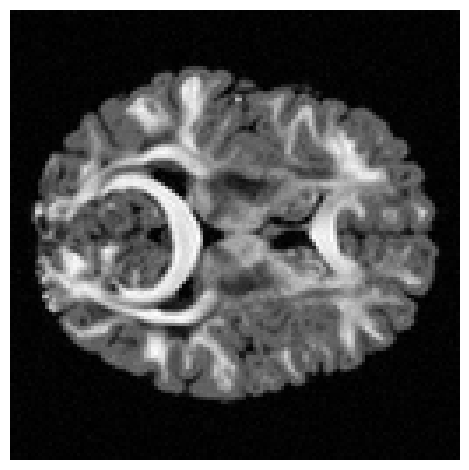

In [2]:
import numpy as np

visualize_single_volume(
                np.transpose(noisy_data, (2,3,0,1)),
            )

In [3]:
# setting checkpoint dir taking into account run/model parameters
checkpoint_dir = os.path.join(
    settings.train.checkpoint_dir,
    f"bvalue_{settings.data.bvalue}",
    f"num_volumes_{settings.data.num_volumes}",
    f"noise_sigma_{settings.data.noise_sigma}",
    f"learning_rate_{settings.train.learning_rate}",
)
os.makedirs(checkpoint_dir, exist_ok=True)


In [4]:
import logging
import os

import numpy as np
import torch
from drcnet.data import ReconstructionDataSet, TrainingDataSet
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from drcnet.reconstruction import reconstruct_dwis
from torch.utils.data import DataLoader
from utils import setup_logging
from utils.checkpoint import load_checkpoint
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import (
    compare_volumes,
    compute_metrics,
    save_metrics,
    visualize_single_volume,
)
from utils.utils import load_config

logging.info("Reconstructing DWIs...")
best_loss_checkpoint = os.path.join(
    checkpoint_dir, "best_loss_checkpoint.pth"
)
reconstruct_model = DenoiserNet(
    input_channels=settings.model.in_channel,
    output_channels=settings.model.out_channel,
    groups=settings.model.groups,
    dense_convs=settings.model.dense_convs,
    residual=settings.model.residual,
    base_filters=settings.model.base_filters,
    output_shape=(
        settings.model.out_channel,
        settings.data.take_x,
        settings.data.take_y,
        settings.data.take_z,
    ),
    device=settings.train.device,
)
reconstruct_model, _, _, _, _ = load_checkpoint(
    model=reconstruct_model,
    optimizer=None,
    filename=best_loss_checkpoint,
    device=settings.reconstruct.device,
)
reconstruct_set = ReconstructionDataSet(noisy_data)
reconstruct_loader = DataLoader(
    reconstruct_set, batch_size=1, shuffle=False
)
reconstructed_dwis = reconstruct_dwis(
    model=reconstruct_model,
    data_loader=reconstruct_loader,
    device=settings.reconstruct.device,
)
logging.info(f"Reconstructed DWIs shape: {reconstructed_dwis.shape}")
logging.info(
    f"Reconstructed DWIs min: {reconstructed_dwis.min():.4f}, "
    f"max: {reconstructed_dwis.max():.4f}, "
    f"mean: {reconstructed_dwis.mean():.4f}"
)


2025-08-04 20:58:48,186 - root - INFO - Reconstructing DWIs...
2025-08-04 20:58:48,187 - root - INFO - Initializing DenoiserNet: input_channels=9, output_channels=1, groups=1, dense_convs=2, residual=True, base_filters=16
2025-08-04 20:58:48,208 - root - INFO - Initializing GatedBlock: x_channels=16, h_channels=16, dense_convs=2, groups=1
2025-08-04 20:58:48,210 - root - INFO - Initializing DenoisingBlock: in_channels=32, inner_channels=16, out_channels=16, inner_convolutions=2, residual=False
2025-08-04 20:58:48,211 - root - INFO - Initializing FactorizedBlock: in_channels=48, out_channels=16, groups=1
2025-08-04 20:58:48,213 - root - INFO - Initializing FactorizedBlock: in_channels=64, out_channels=16, groups=1
2025-08-04 20:58:48,216 - root - INFO - Attempting to load checkpoint from: drcnet/checkpoints/dbrain/bvalue_2500/num_volumes_10/noise_sigma_0.01/learning_rate_0.0001/best_loss_checkpoint.pth
2025-08-04 20:58:48,469 - root - INFO - Checkpoint loaded successfully: drcnet/checkp

In [5]:
reconstructed_dwis.shape

(10, 128, 128, 96)

(96, 10, 128, 128)


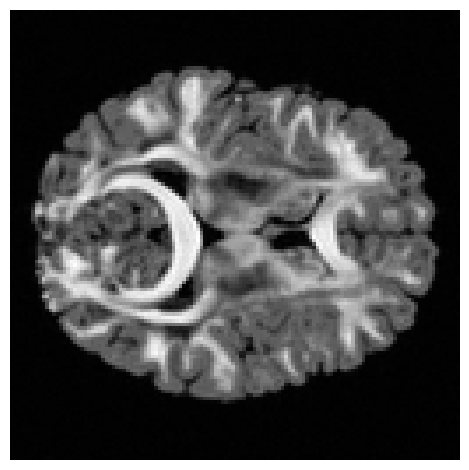

(96, 10, 128, 128)


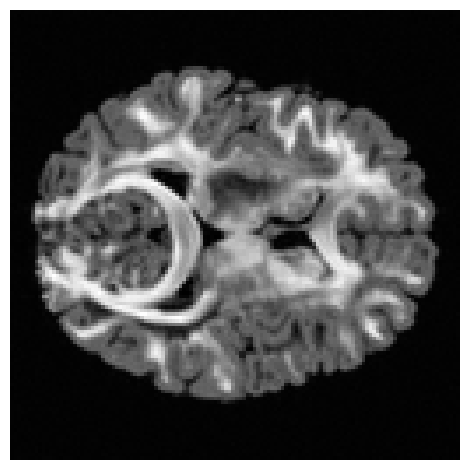

(96, 10, 128, 128)


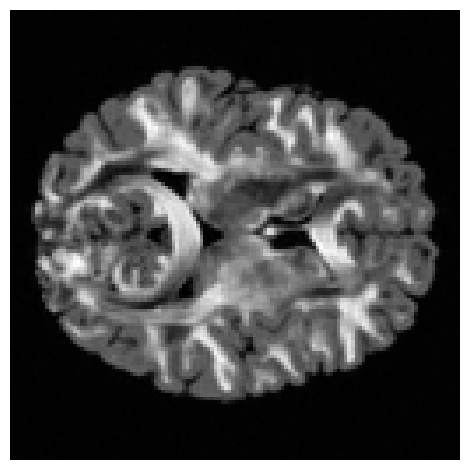

(96, 10, 128, 128)


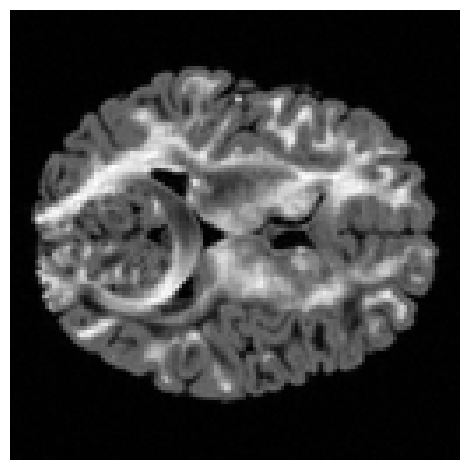

In [8]:
for i in range(4):
    visualize_single_volume(
                np.transpose(reconstructed_dwis, (3, 0, 1, 2)),
    volume_idx=i,
        #slice_idx=55
            )

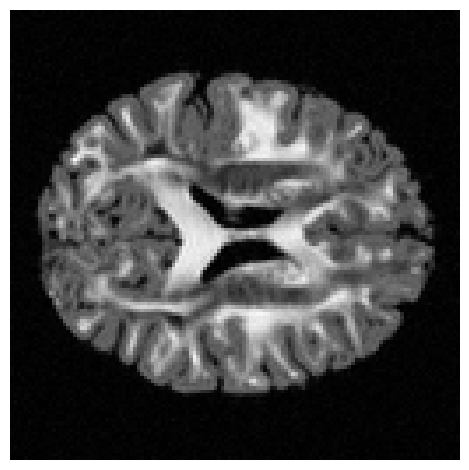

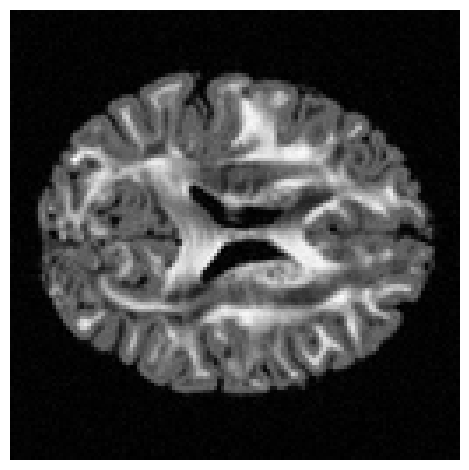

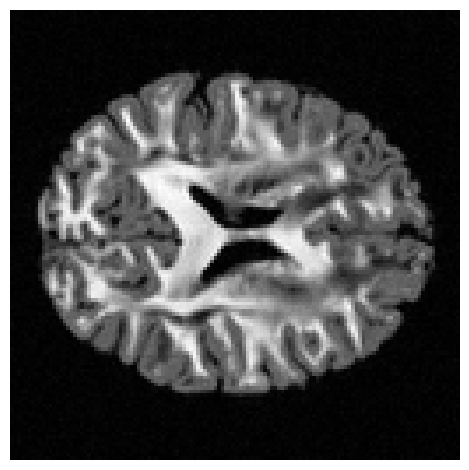

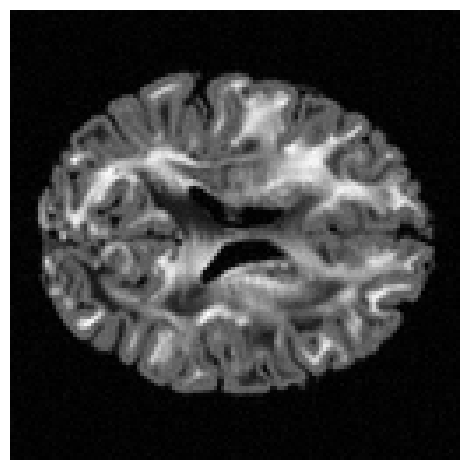

In [7]:
for i in range(4):
    visualize_single_volume(
                np.transpose(noisy_data, (2,3,0,1)),
    volume_idx=i,
        slice_idx=55
            )